<a href="https://colab.research.google.com/github/weiweitoo/airline-twitter-sentiment/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Setup

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
# !pip install fastai

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
root_path = "drive/My Drive/Colab Notebooks/AirlineTweetSentiment"
df = pd.read_csv(root_path + "/Tweets.csv")

# Data Preparation

## Utils

In [0]:
def plot_bar(dictionary, title):
  plt.figure(figsize=(8,6))
  plt.title(title)
  bar_plot = plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
  plt.xticks(range(len(dictionary)), list(dictionary.keys()), rotation=45)
  plt.show()
  return plt, bar_plot

## Data Preparation for Sentiment Analysis

In [154]:
total_data_size = df.shape[0]
print(f'Total Size :{total_data_size}')

Total Size :14640


In [155]:
df['airline_sentiment_confidence'].describe()


count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

In [156]:
df = df[df['airline_sentiment_confidence'] > 0.67]
confident_sentiment_size = df.shape[0]
print(f'Confident Sentiment Data Size :{confident_sentiment_size}')

Confident Sentiment Data Size :12283


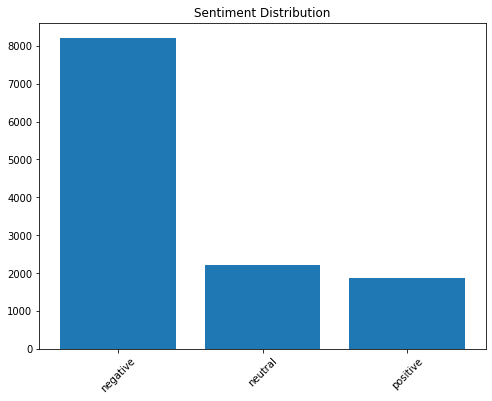

In [157]:
airline_sentiment = df['airline_sentiment'].value_counts()
plt, bar_plot = plot_bar(airline_sentiment.to_dict(), "Sentiment Distribution")

In [161]:
airline_sentiment

negative    8201
neutral     2201
positive    1881
Name: airline_sentiment, dtype: int64

## Data Preparation for Negative Reason

In [158]:
df_reason = df.dropna(subset=['negativereason'])
print(f'Reason Data Size :{df_reason.shape[0]}')

Reason Data Size :8201


In [159]:
df_reason = df_reason[df_reason['negativereason_confidence'] > 0.67]
print(f'Confident Reason Data Size :{df_reason.shape[0]}')

Confident Reason Data Size :5341


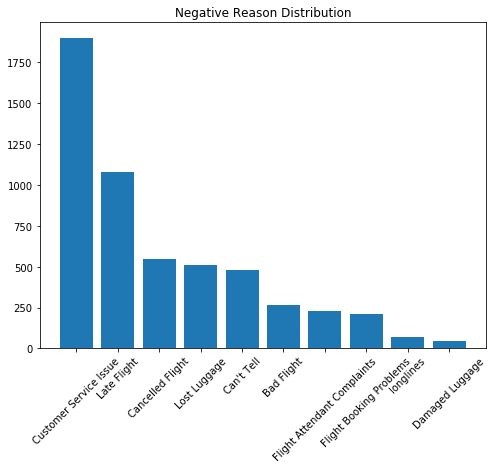

Customer Service Issue         1900
Late Flight                    1079
Cancelled Flight                546
Lost Luggage                    511
Can't Tell                      477
Bad Flight                      268
Flight Attendant Complaints     232
Flight Booking Problems         211
longlines                        72
Damaged Luggage                  45
Name: negativereason, dtype: int64

In [160]:
negative_reason = df_reason['negativereason'].value_counts().to_dict()
plot_bar(negative_reason, "Negative Reason Distribution")
df_reason['negativereason'].value_counts()

# Sentiment Analysis Training

In [0]:
def construct_input(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  col_names = ['labels','text']
  df_trn = pd.DataFrame({'text':X_train, 'labels':y_train}, columns=col_names)
  df_val = pd.DataFrame({'text':X_test, 'labels':y_test}, columns=col_names)
  data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)
  data_clas = TextClasDataBunch.from_df(path = "./", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)
  data_lm.save('tmp_lm')
  data_clas.save('tmp_clas')
  return data_lm, data_clas

def learn_language_model(data_lm):
  learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
  learn.freeze_to(-2)
  learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))
  learn.save_encoder("ft_enc")
  return learn

def learn_classification_model(data_clas):
  learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
  learn.load_encoder('ft_enc')
  learn.freeze_to(-2)
  learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))
  return learn

In [166]:
X = df_high_confident['text']
y = df_high_confident['airline_sentiment']
data_lm, data_clas = construct_input(X, y, 0.3)

In [0]:
learner_lm = learn_language_model(data_lm)
learner_clas = learn_classification_model(data_clas)

epoch,train_loss,valid_loss,accuracy,time


In [0]:
learner_lm.export('')

# Negative Reason Prediction

In [0]:
X = df['text']
y = df['negativereason']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
data_lm, data_clas = construct_input(X, y, 0.3)

In [0]:
learner_lm = learn_language_model(data_lm)
learner_clas = learn_classification_model(data_clas)